In [1]:
from toolz.curried import *

import pandas as pd
import numpy as np
from scipy.special import expit

import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib


from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

#### Noncompliance and Instruments

Companies commonly offer products and services to existing customer base. In such cases, the customer must opt in for the additional product or service which confounds the evaluation of the service. This is because, customers who opt in and customers who don't likely have different $Y_0$. Even if the company randomizes the availability of the service or products, it can't force customers to take it. This is called noncompliance, where not everyone that gets assigned to the treatment takes it. 

Noncompliance comes from pharmaceutical science. Imagine an experiment to test the effect of new drug on some illness. Each subject gets assigned the treatment (drug) or a placebo (control). Some subjects will forget to take their medicine, so that not everyone assigned to the treatment gets it. Also someone critically ill might figure out that they were assigned the placebo and manage to find to get their hands on the treatment regardless. That is if you separate the treatment assignment from the treatment intake, you end up with four groups:

- Compliers: Those who take the treatment that was assigned to them

- Always takers: Thos who always take the treatment, regardless of the assignment

- Never takers: Those who never take the treatment, regardless of the assignment

- Defiers : Those who take the opposite treatment from the one assigned

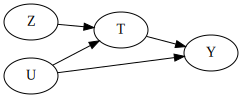

In [2]:
from graphviz import Digraph

gr = Digraph(format="png", graph_attr={"rankdir": "LR"})

gr.edge("U", "T")       # U is hidden factors that confound treatment choice and outcome (compliance)
gr.edge("U", "Y")       # Y is the outcome
gr.edge("Z", "T")       # Z is the treatment assignment (random in this case)
gr.edge("T", "Y")       # T is th treatment

gr

In the DAG above, $Z$ is the treatment assignment (random in this case), $T$ is the treatment, $Y$ is the outcome, and $U$ is the hidden factors that confound the treatment choice and the outcome. $Z$ is what is called <i>an instrument</i>: a variable that (1) impacts the treatment in an unconfounded way and (2) doesn't impact the outcome, unless through the treatment.

The compliance group and the treatment assignment deterministically cause the treatment intake, so you can think of U as unknown factors that cause the compliance group. Without further assumption, you can't identify the effect of the treatment on Y due to an open backdoor path through U. Identification of that effect will involve clever usage of Z.

Consider a typical industry setting such as a bank that wants to know the impact of offering a prime credit card to its customers. Since the prime service is costly, the bank charges a small fee, which is not enough to cover all its costs. If the purchase volume - the total amount spent on the card - of those prime customers increases by at least 500 USD, then it is worth it. Hence bank wants to know how much the prime card increases customer's purchase volume.  The bank run an experiment where it randomized the availability of the prime credit card to 10,000 customers, with each customer having a 50% of being in control. The bank can't force customers to choose the card, making this an experiment with non-compliance. In this dataset, purchase volume would be outcome Y, availability of the prime credit would be treatment assignment Z, having the prime card would be treatment T. Since this is  simulation data, information not available in real life is given; the true effect of the prime card on purchase volume, $\tau$ (tau) and which compliance group a customer belongs to (complier,defier, always taker, never taker). The bank also has information on customer's age, income, and credit score.

In [3]:
df = pd.read_csv("data/prime_card.csv")
df.columns

Index(['age', 'income', 'credit_score', 'prime_elegible', 'prime_card', 'pv',
       'tau', 'categ'],
      dtype='object')

In [4]:
df['prime_eligible'] = df['prime_elegible'] # add new column off renaming mispelled column

In [5]:
df.head()

,age,income,credit_score,prime_elegible,prime_card,pv,tau,categ,prime_eligible
0,37.7,9687.0,822.0,0,0,4913.79,700.0,complier,0
1,46.0,13731.0,190.0,0,0,5637.66,200.0,never-taker,0
2,43.1,2839.0,214.0,1,1,2410.45,700.0,complier,1
3,36.0,1206.0,318.0,1,1,1363.06,700.0,complier,1
4,39.7,4095.0,430.0,0,0,2189.80,700.0,complier,0


#### Extending Potential Outcomes

To be more precise with noncompliance and to proceed with identification, you'll have to extend potential outcome notation. Since $Z$ causes $T$, we can define a $potential\;treatment\;T_z$. Also, the potential outcome has new counterfactuals with respect to the instrument $Z,Y_{z,t}$. $Z$ is randomized which means that its effect on $Y$- called the <i>intention-to-treat effect</i> (ITTE) is pretty easy to identify by estimating with a simple linear regression.

$ITTE=E[Y|Z=1]-E[Y|Z=0]=E[Y_{1,t} - Y_{0,t}]$

The <i>ITTE</i> measures the impact of assigning a treatment, such as offering the prime credit card. For the bank, this number indicates the additional purchase volumne (PV) per customer it can expect by having the prime credit card available as part of its product suite. However, the ITTE is not the treatment effect. The bank's primary objective is to determine whether the benefits of the prime card outweigh its costs. The bank needs to identify the treatment effect of choosing the card, rather than solely relying on the ITTE.

In [6]:
# estimating ITTE with linear regression
m = smf.ols("pv~prime_eligible", data=df).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_eligible,321.3880,34.321,9.364,0.000,254.113,388.663


In this particular example, the bank has full control on who has the prime card available. As a result, you have one-sided noncompliance, since there is no way for customers who are not eligible for the prime card to get it, but customers who have the card can still choose to not have it. This forces the always takers into compliance (they can only take treatment if offered) and the defiers into never takers (they can only defy treatment assignment if offered), reducing the number of compliance groups from four to two.

Due to randomization of treatment assignment, the ITTE can be obtained by comparing those assigned to the treatment to those assigned to the control. This comparison will give a <i>biased toward zero estimate for the treatment effect</i>. That's because some of those assigned to the treatment actually take the control (never takers), which decreases the perceived difference between the two groups.  Comparing the <i>taus</i> added to the dataset, the average treatment effect is quite larger than the ITTE (412 vs 321). 

Taking the measured effect, which is a simple average comparison between those who actually took the treatment versus those who actually took the control, $E[Y|T=1]-E[Y|T=0]$, to see if the randomization assignment makes a good proxy for the effect estimate, we discover that the measured effect for this dataset is much larger than the true effect (588 vs 412). The reason is that in this example, the bias is upward ie $E[Y_0|T=1]>E[Y_0|T=0]$, meaning that customers who choose the prime card spend more regardless of the prime card. In other words, the never takers have lower $Y_0$ than the compliers, which artificially lowers the average outcome of the untreated group.

In [7]:
df.categ.unique()   # bank controls treatment assignment leading to two compliance groups

array(['complier', 'never-taker'], dtype=object)

In [8]:
df.query("prime_eligible!=prime_card").head()  # never takers

,age,income,credit_score,prime_elegible,prime_card,pv,tau,categ,prime_eligible
6,32.3,3771.0,126.0,1,0,2288.43,200.0,never-taker,1
7,40.3,10786.0,221.0,1,0,4972.09,200.0,never-taker,1
11,41.6,3437.0,41.0,1,0,1910.92,200.0,never-taker,1
13,39.4,3272.0,28.0,1,0,1460.20,200.0,never-taker,1
14,40.2,14654.0,226.0,1,0,6281.98,200.0,never-taker,1


In [9]:
# ATE 
df["tau"].mean()  # ITTE was 321 so less than actual ATE

413.45

In [10]:
# measured effect E[Y|T=1] - E[Y|T=0]
m = smf.ols("pv~prime_card", data=df).fit()    # regress output on actual treatment
m.summary().tables[1]       # measured effect is 588, so larger than true effect

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2534.4947,19.239,131.740,0.000,2496.783,2572.206
prime_card,588.1388,41.676,14.112,0.000,506.446,669.831


#### Instrument Identification Assumptions

1. First assumption is independence. That there are no unmeasured confounders between Z and T, $T_z\;⊥\;Z|X$, and between Z and Y, $Y(Z,T_z)\;⊥\;Z|X$. This assumption states that the instrument is as good as randomly assigned. This assumption is made more plausible by the experiment design. In our example, this assumpition is satisfied since the bank randomized the availability of the prime card.

2. Second assumption is exclusion restriction, $Y_{z,t}=Y_t$, which is the lack of a path from Z to Y that does not go through the treatment T. The instrument only affects outcome through treatment. Even if Z is randomized, it could impact the outcome through other channels. Say customers found out which group they were assigned to and those in control got mad at the bank and decided to close their accounts. This would mean no purchase volume will be measured for those who closed their accounts, affecting the measured control output. In this case, randomization affects the outcome through a channel that is not the treatment.

3. The third assumption is relevance, $E[T_1 - T_0]\neq0$, which is the existence of a path from Z to T. This assumptiion states that the instrument must have an influence on the treatment. This assumption is testable, since you can estimate the effect of the instrument on the treatment.

4. The final assumption is <i>monotonicity</i>, $T_{i1} \geq T_{i0}$ (or vice versa). This simply states that the instrument flips the treatment in only one direction. It either increases the chance of getting the treatment for everyone who got the instrument ie there are no defiers; or it decreases that chance ie there are no compliers. In the example dataset, this is plausible since customers in the control group can't force their way into getting the prime credit card. The defiers are collapsed into never takers.

Expanding observed outcome into potential outcomes using the treatment as a switch ie $Y=Y_1T + Y_0(1-T)$ to calculate the ITTE:

$E[Y|Z=1] - E[Y|Z=0] = E[Y_{1,1}T_1 + Y_{1,0}(1-T_1)|Z=1]\;- E[Y_{0,1}T_0 + Y_{0,0}(1-T_0)|Z=0]$

Now, because of the exclusion restriction, we can remove the instrument subscript of $Y_{z,t}$

$E[Y_1T_1 + Y_0(1-T_1)|Z=1]\;- E[Y_1T_0 + Y_0(1-T_0)|Z=0]$

Using the independence assumption, you can merge both expectations:

$E[Y_1T_1 + Y_0(1-T_1) - Y_1T_0 - Y_0(1-T_0)]$

$E[(Y_1-Y_0)(T_1-T_0)]$

Using the monotonicity assumption and expand this expectation into possible cases, $T_1>T_0$ and $T_1=T_0$:

$E[(Y_1-Y_0)(T_1-T_0)|T_1 > T_0]*P(T_1>T_0) + E[(Y_1-Y_0)(T_1-T_0)|T_1 = T_0]*P(T_1=T_0)$

If $T_1=T_0$ then $T_1 - T_0$ would be 0. Also, since Z is binary $T_1-T_0=1$:

$E[Y|Z=1]-E[Y|Z=0]=E[Y_1-Y_0|T_1 > T_0]*P(T_1>T_0)$

$T_1>T_0$ are the compliers, the population where the instrument shifts the treatment from 0 to 1. This means the effect of the instrument on the outcome is the treatment effect of the compliers times the compliance rate. This explains why the ITTE is a biased-toward-zero estimate for this effect: you are multiplying it by a rate, which is between 0 and 1. Being able to estimate $P(T_1>T_0)$, then you would be able to correct the previous estimator.

Because the instrument is randomized, you can estimate its impact on the treatment, $E[T_1-T_0]$. Since $T_1-T_0=1$ is for compliers and 0 otherwise (due to monotonicity assumption), this effect is the compliance rate:

$E[T_1-T_0]=P(T_1>T_0)$

This means you can identify the average treatment effect on the compliers by scaling up the effect of the instrument on the outcome by the compliance rate, which is the effect of the instrument on the treatment:

$E[Y_1-Y_0|T_1>T_0]=\frac{E[Y|Z=1]- E[Y|Z=0]}{E[T|Z=1]- E[T|Z=0]}$

This effect is not the ATE, but only the effect on the compliers, usually called the local average treatment effect (LATE). In a noncompliance setting, you can't identify the ATE. In the credit card example, the LATE would be the effect on those who choose the prime card when it is available to them. The bank wants to know, if the effect, in terms of extra PV, compensate for the cost of the prime card, both of which only occur for those who choose the prime card. So in this case, it is enough to know the LATE. The bank doesnt care about the effect of those who will never opt in for the prime card.

#### First Stage

The first step in instrumental variables analysis is to run a first stage regression, where you regress the treatment on the instrument. During this step, you can check the relevance assumption. If the instrument parameter estimate is large and statistically significant, you can believe the relevance assumption.

In this example, the compliance rate (effect of instrument on treatment) is about 42% (0.4242), and is statistically significant P>|t| is 0.000 with a 95% confidence interval of [0.410, 0.438]

In [11]:
# regress treatment against instrument
first_stage = smf.ols("prime_card ~ prime_eligible", data=df).fit() # T = f(Z)
first_stage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.729e-15,0.005,1.35e-12,1.000,-0.010,0.010
prime_eligible,0.4242,0.007,60.536,0.000,0.410,0.438


In [12]:
# checking actual compliance rate using counterfactual
df.groupby("categ").size()/len(df)

categ
complier       0.4269
never-taker    0.5731
dtype: float64

#### Reduced Form

The second step is called the reduced form. You regress the outcome on the instrument to obtain the intention to treat effect (ITTE). Once you've run the first stage and reduced dorm, you divide the parameter estimate from the first by the parameter estimate on the latter to obtain the estimate for the local average treatment effect (LATE). The LATE is more than twice the ITTE, which is expected since the compliance rate is lower than 50%. The LATE is also higher than the ATE because compliers have a higher than average effect. The estimated LATE (757) is still different from the effect for the compliers only (700), and so we need a confidence interval to verify if this difference is statistically significant. We could use bootstrap but there is an actual formula for the standard error of instrumental variable (IV) estimates, which relies on an alternate way to estimate the LATE.

In [13]:
red_form = smf.ols("pv ~ prime_eligible", data=df).fit()    # Y = f(Z)
red_form.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_eligible,321.3880,34.321,9.364,0.000,254.113,388.663


In [14]:
late = (red_form.params["prime_eligible"] / first_stage.params["prime_eligible"]) 
late

757.6973795343938

In [15]:
# comparing estimated LATE to the effect for compliers
df.groupby("categ")["tau"].mean()

categ
complier       700.0
never-taker    200.0
Name: tau, dtype: float64

#### Two-Stage Least Squares

The treatment is caused by two components: first, there is the random componenet, which is the randomized instrument. Second, there is the U component, where the confounding bias comes from. The first stage regression of the treatment on the instrument , essentially estimates the path $Z → T$. You can think of the first stage predicted values, $\hat T$, as an unbiased version of the treatment. This means if you regress the outcome on those predicted values, you'll get the same instrumental variable (IV) estimate (LATE) as before. This approach is called <i>two-state least squares (2SLS)</i>. 2SLS allows you to properly compute standard errors. 2SLS also makes adding more instruments and covariates as easy as adding variables in a regression model.

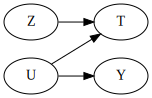

In [16]:
gr = Digraph(format="png", graph_attr={"rankdir":"LR"})

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr

In [17]:
ivr_regr = smf.ols(
    "pv ~ prime_card", # regress the outcome against the first state regression predicted values
    data=df.assign(prime_card=first_stage.fittedvalues)).fit()
ivr_regr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2498.3618,24.327,102.701,0.000,2450.677,2546.047
prime_card,757.6974,80.914,9.364,0.000,599.091,916.304


#### Standard Error of Instrumental Variables

We can define residuals from the second stage as follows:

$\hat e_{IV}=\; Y - \hat \beta _{IV}T$

Notice that this is not the same residuals you would get with the <i>.resid</i> method from the second stage, since those would be $Y - \hat \beta _{IV} \hat T$. The residual you want uses the raw version of the treatment, not the predicted one. With that residual, you can compute the standard error for the IV estimates:

$SE(\hat \beta _{IV})=\frac{\sigma(\hat \epsilon _{IV})}{\hat \beta _{z,1st}\sigma (Z)\sqrt n}$

where $\sigma (.)$ is the standard deviation function and $\beta _{z,1st}$ is the estimated compliance rate, which you get from the first stage.

We can also use the <i>2SLS</i> module from linearmodels' Python package. With it, you can wrap the first stage, as in $[T$ ~ $Z]$ and fit an instrumental variable (IV) model. 

In [18]:
Z = df["prime_eligible"]        # instrument
T = df["prime_card"]            # treatment
n = len(df)                     # sample size, number of customers in dataset


e_iv = df["pv"] - ivr_regr.predict(df)      # predict using original treatment; different from ivr_regr.resid!
compliance = np.cov(T,Z)[0,1]/Z.var()       # compliance rate (regression estimate as covariance/variance)

se = np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n))     # standard error of late using formula

print("SE IV:", se)                         # standard error for instrumental variable
print("95% CI:", [late -2*se, late + 2*se])

SE IV: 80.52861026142209
95% CI: [596.6401590115496, 918.754600057238]


In [21]:
# Using linearmodels package 2SLS module
from linearmodels import IV2SLS

formula = 'pv ~ 1 + [prime_card ~ prime_eligible]'
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")
iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,2498.4,24.211,103.19,0.0000,2450.9,2545.8
prime_card,757.70,80.529,9.4090,0.0000,599.86,915.53


The standard error formula shed some light on the challenges of noncompliance experiments. First, $\sigma (Z)$ is in the denominator, and since $Z$ is a binary variable, the maximum value for $\sigma(Z)$ is 0.5. In OLS with binary treatment, the standard error is 

$\sigma (\hat e)/(\sigma(T)\sqrt n)$. 

This simply states that you can maximize the power of a test by randomizing the treatment in a 50%-50% fashion. But the standard error formula for IV contains an extra term in the denominator compared with OLS standard error and this is the compliance rate $\hat \beta_{z,1st}$. This means that if compliance is 100%, then $Z=T, \hat \beta _{z,1st}=1$ and you get back the OLS standard error. But with noncompliance, the standard error increases since $\hat \beta _{z,1st} < 1$. For instance, with 50% compliance, the IV standard error will be twice as large as the OLS standard error. As a result, the required sample size for an experiment with 50% compliance is 4x the sample you need if you had 100% compliance.

The IV estimates are consistent, but not unbiased, ie $E[\beta _{IV}] \neq \beta$. This is mostly due to sampling error in the first stage. Since you don't have infinite data, the fitted value for the treatment, $T$, will be a functioin of both $Z$ and $U$, meaning that not all the bias will go away. As you gather more data $\hat T$ will become less and less a function of $U$. That is why the estimator is consistent, meaning $plim_{n→∞}\beta_{IV}=\beta$.

50% compliance is still a lot. In most applications, only a small fraction of customers opt in for the prime service or product, which makes it even harder to estimate the LATE. For instance, if compliance is 30%, you'll need a sample 10x larger than the one you would need if compliance were not an issue. Such a big sample is impractical, sometimes impossible. There are techniques to lower IV standard error by using extra covariates.

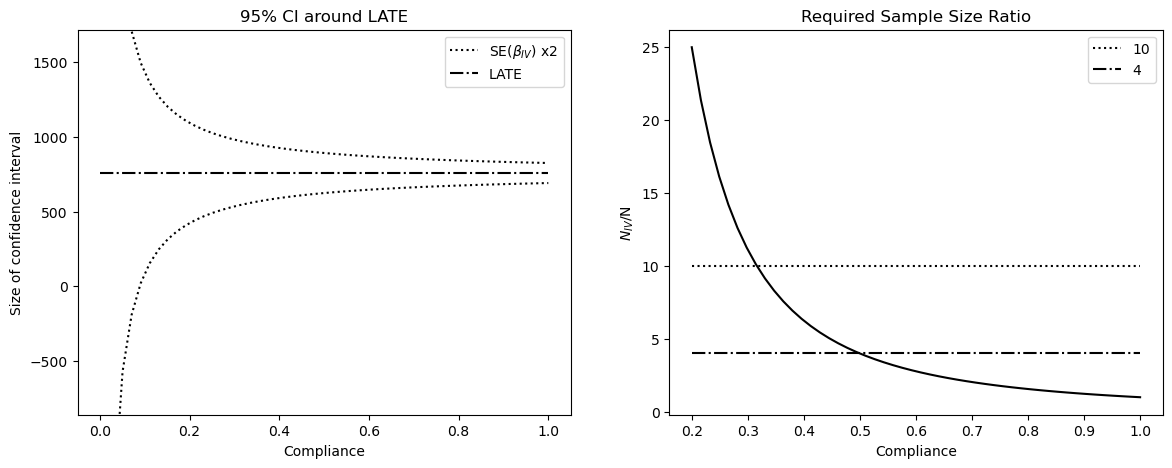

In [29]:
se_formula_iv = lambda compliance: np.std(e_iv)/(compliance*np.std(Z)*np.sqrt(n)) #standard error calculation
x = np.linspace(0.01, 1, 50)

effect = ivr_regr.params["prime_card"]   # late

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.plot(x, effect - se_formula_iv(x)*1.96, label="SE($\\beta_{IV}$) x2", ls=":", color="0") # left end CI
ax1.plot(x, effect + se_formula_iv(x)*1.96, ls=":", color="0") # right end CI, 95% CI is ~ 2 (1.96) std from mean
ax1.hlines(effect, 0, 1, ls="-.", label="LATE")
ax1.set_xlabel("Compliance")
ax1.set_ylabel("Size of confidence interval")
ax1.set_ylim(-(effect+100), (effect+100)*2)
ax1.legend()
ax1.set_title("95% CI around LATE")

x = np.linspace(0.2, 1, 50)
ax2.plot(x, 1/(x**2))
ax2.hlines(10, 0.2, 1, ls=":", label="10")
ax2.hlines(4, 0.2, 1, ls="-.", label="4")
ax2.set_xlabel("Compliance")
ax2.set_ylabel("$N_{IV}$/N")
ax2.set_title("Required Sample Size Ratio")
ax2.legend()

#### Additional Controls and Instruments

To lower the IV standard error, we need to include extra covariates in the analysis. For the prime card example, three additional covariates, besides the treatment, the instrument, and outcome are added. The are the customer's income, age, and credit score. Income is highly predictive of the outcome (purchase volume), but doesn't predict compliance; credit score predicts compliance, but not the outcome, and age predicts both of them (is a confounder).
We can decrease the standard error by cleverly using these variables.

Credit score causes compliance, but does not cause outcome. This means that it can be treaed as an additional instrumental variable. From the DAG below, it satisfies the first three IV assumptions, just like Z. You only have to assume positivity. Including that variable as an extra IV in your 2SLS model will significantly reduce the standard error of the LATE parameter. If instead of treating it as an instrument, you condition on it, adding it to the second stage too, the error will increase, because conditioning on variables that cause the treatment, but not the outcome will increase variance. Unless you know the instrument assignment mechanism, it is hard to know if the exclusion restriction holds. 

In real life, it's most likely a covariate affects both compliance and the outcome, which is the case with age here. In that case, an approach to reducing the variance of the IV estimate is to include controls that are highly predictive of the outcome. Customer income is very predictive of purchase volumne, so including it as an additional control will lower the standard error quite substantially. The effect of variables like age, which affect both the outcome and compliance, is nuanaced. Like with the regression case, if it explains the treatment a lot more than the outcome, it might end up increasing the variance.

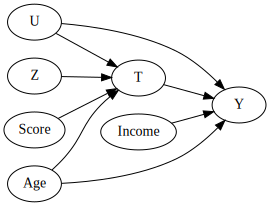

In [37]:
gr = Digraph(format="png", graph_attr={"rankdir": "LR"})

gr.edge("U", "T")
gr.edge("U", "Y")
gr.edge("Z", "T")
gr.edge("T", "Y")
gr.edge("Income", "Y")
gr.edge("Age", "Y")
gr.edge("Age", "T")
gr.edge("Score", "T")

gr

In [38]:
# Credit score as an additional instrumental variables, using linearmodels package 2SLS module
formula = 'pv ~ 1 + [prime_card ~ prime_eligible + credit_score]'
iv_model = IV2SLS.from_formula(formula, df).fit()
iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,2519.4,21.168,119.02,0.0000,2477.9,2560.9
prime_card,659.04,58.089,11.345,0.0000,545.19,772.90


In [39]:
# Including Age, Income Controls
formula = '''pv ~ 1 
            + [prime_card ~ prime_eligible + credit_score]
            + income + age'''
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="unadjusted")
iv_model.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,210.62,37.605,5.6008,0.0000,136.91,284.32
age,9.7444,0.8873,10.982,0.0000,8.0053,11.483
income,0.3998,0.0008,471.04,0.0000,0.3981,0.4014
prime_card,693.12,12.165,56.978,0.0000,669.28,716.96


#### 2SLS by hand

We have implemented 2SLS (two-stage least squares) using a specialized Python package. But doing with common techniques is also possible. If you have more than one instrument and additional covariates, you can include them in your model by:

1. Running the first stage, regressing the treatment on instrumentals and additional covariates, $T$ ~ $Z+X$.
2. Running the second stage by regressing the outcome on the treated fitted values (from the first stage) and the additional covariates, $Y$~$T_{hat} + X$.

In [40]:
# 2SLS with multiple instrument and covariates,  Z = prime_eligible, credit_score  X= income, age
formula_1st = "prime_card ~ prime_eligible + credit_score + income + age" 
first_stage = smf.ols(formula_1st, data=df).fit()

iv_model = smf.ols(
    "pv ~ prime_card + income + age",
    data = df.assign(prime_card = first_stage.fittedvalues)).fit()

iv_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,210.6177,40.832,5.158,0.000,130.578,290.657
prime_card,693.1207,13.209,52.474,0.000,667.229,719.013
income,0.3998,0.001,433.806,0.000,0.398,0.402
age,9.7444,0.963,10.114,0.000,7.856,11.633


#### Matrix Implementation

The implementation of 2SLS by hand shown above,  will give the exact same IV estimate as the one obtained with linearmodels, but the standard errors will be off. To get reliable standard error values, you are probably better off with the matrix implementation of 2SLS. To do that, you have to append the additional covariates into both the treatment and the instrument matrix, and the IV estimate is as follows:

$\hat X = Z(Z^{'}Z)^{-1}Z^{'}X$

$\beta_{IV} = (\hat X^{'} \hat X)^{-1}\hat XY$

When coding it up, you just have to be careful with large $N$. $Z(Z^{'}Z)^{-1}Z^{'}$ will be a huge $N$ x $N$ matrix, which can be avoided if you first multiply $(Z^{'}Z)^{-1}Z^{'}X$ and pre-multiply $Z$.

Once you compute the same coefficieint with the matrix implementation (as with the hand calculation), you can compute the IV residuals and variance:

$\widehat {Var} (\hat \beta _{IV})=\sigma ^ 2 (\hat e _{iv})diag((\hat X^{'}\hat X)^{-1})$

The variance formula is a bit harder to interpret, due to the matrix notation. An approximate and more explainable formula for standard error is :

$SE(\widehat \beta _{IV}) \approx \frac{\sigma(\hat e_{IV})}{\sigma (\tilde T)\sqrt {nR^2_{1st}}}$

Here, $\tilde T$ is the residuals of the treatment regressed on the additional covariates, but not the instrument, and $R^2_{1st}$ is the $R^2$ from the first stage. With this formula, you can see that, aside from increasing sample size, you have three levers to decrease the standard error:

1. Increasing the first stage R^2. This can be done by finding strong instruments, which are variables that are good at predicting compliance, but satisfy the exclusion restriction (do not cause the outcome).

2. Removing variables that are highly predictive of T in order to increase $\sigma(\tilde T)$.

3. Decreasing the size of the second stage residuals, which can be done by finding variables that are highly predictive of the outcome.

It is very hard to find IVs in the wild. Also, there is only so much you can remove in order to decrease $\sigma(\tilde T)$. Thus, the only reliable way to decrease the variance is to find variables that are good at predicting the outcome.

In [42]:
# LATE with matrix implementation of two-stage least squares
Z = df[["prime_eligible", "credit_score", "income", "age"]].values # instrument and additional covariates matrix
X = df[["prime_card", "income", "age"]].values                     # treatment and additional covariates matrix
Y = df[["pv"]].values                                              # outcome

def add_intercept(x):
    return np.concatenate([np.ones((x.shape[0],1)),x],axis=1) # 1 row of 1s, concatenate column wise

Z_ = add_intercept(Z)   # add intercept to instrument and additional covariate matrix
X_ = add_intercept(X)   # add intercept to treatment  and additional covariate matrix

# pre-multiplying Z_.dot(...) last is important to avoid creating a huge NxN matrix
X_hat = Z_.dot(np.linalg.inv(Z_.T.dot(Z_)).dot(Z_.T).dot(X_))       # predictions with matrix 2SLS
b_iv = np.linalg.inv(X_hat.T.dot(X_hat)).dot(X_hat.T).dot(Y)        # coefficients
b_iv[1]             # intercept, prime_card, income, age (from X)

array([693.12072518])

In [43]:
# variance of matrix implementation of two-state least squares
e_hat_iv = (Y - X_.dot(b_iv))               # errors / residuals using intercept, prime_card, income, age
var = e_hat_iv.var()*np.diag(np.linalg.inv(X_hat.T.dot(X_hat)))     # variance with formula
np.sqrt(var[1])                             # standard error

12.164694395033125

In [46]:
# alternate formulation of standard error
t_tilde = smf.ols("prime_card ~ income + age", 
                  data=df).fit().resid # regress treatment on additional covariates to get the residual

e_hat_iv.std() / (t_tilde.std()*np.sqrt(n*first_stage.rsquared))

12.156252763192532

#### Discontinuity Design

Regression discontinuity design (RDD) is another design for noncompliance in addition to traditional instrumental variables. RDD leverages artificial discontinuities in the treatment assignment to identify the treatment effect. 

Suppose a government implements a money transfer program that offers poor families a monthly check of 200 USD in the local currency, but only families earning less than 50 USD are eligible. This creates a discontinuity in the program's assignment at 50 USD, allowing researchers to compare families just above and just below the threshold to measure the program's effectiveness, provided that the two groups are similar. Discontinuities are pervasive, making RDD very attractive to researchers. For example to understand the impact of college, researchers can compare people who scored just above, and just below a passing threshold in an admission exam. To assess the impact of women on politics, researchers can compare cities where a female candidate lost by a small margin to those where a female candidate won by a small margin.

RDD happens in industry too. Suppose a bank offers a credit card to all its customers, but charges a fee to those with an account balance below 5,000 USD. This creates discontinuity in the way the card is offered, where customers with balances above the threshold are more likely to choose the prime card, while those with balances below the threshold are not. Thus, RDD can be applied to compare the effects of having a prime card versus a regular card, provided that customers above and below the threshold are similar in other respects.

Firms could easily conduct experiments to randomize eligibility, limiting the use of discontinuity designs. However, running such experiments could be time-consuming, possibly because the required sample is too big, due to low compliance. In contrast, the bank in question has data following the discontinuity design. Therefore the bank can leverage this data to determine the effect of the prime credit card. 

The basic idea is to recognize the threshold can be understood as an instrument since crossing it increases the likelihood of receiving the treatment. Discontinuity design relates to instrumental variables since the instrument is crossing the 5,000 USD threshold and as such you can observe $T_0$ when $balance<5000$ and $T_1$ otherwise. Since the instrument increases the chance of getting the treatment (the prime card), there is a jump in P(T=1) once you cross the threshold. The probability of treatment will be less than one, even above the threshold, making the outcome you observe above the threshold, less than the true potential outcome $Y_1$. In the same way, the outcome you observe below the threshold is higher than true potential outcome $Y_0$. This makes it look like the treatment effect at the threshold is smaller than it actually is and you will have to use IV to correct for that.

#### Discontinuity Design Assumptions

Besides the IV assumptions, discontinuity design requries one further assumption about the smoothness of the potential outcomes and potential treatment functions. Define a running variable R such that the treatment probability is a discontinuous function of that variable at a threshold $R=c$. In banking example, R would be the account balance and $c=5000$.

$lim _{r→c^-}\;E[Y_t|R=r] = lim _{r→c^+}\;E[Y_t|R=r]$

$lim _{r→c^-}\;E[T_z|R=r] = lim _{r→c^+}\;E[T_z|R=r]$

In otherwords, the potential outcome $Y_t$ and potential treatment $T_z$ at the discontinuity $R=c$ are the same if you approach them from the left or from the right. With those assumptions, the local average treatment effect estimator for a discontinuous design is:

$LATE=\dfrac{lim _{r→c^+}\;E[Y|R=r] - lim _{r→c^-}\;E[Y|R=r]}{lim _{r→c^+}\;E[T|R=r] - lim _{r→c^-}\;E[T|R=r]}$

$LATE=E[Y_1-Y_0|T_1>T_0, R=c]$

This estimator is local in two senses. First, it is local because it only gives the treatment effect at the threshold $R=c$. This is the discontinuity design locality. Second, it is local because it only estimates the treatment effect for the compliers. This is the IV locality.

#### Intention to Treat Effect

The jump in the observed outcome at the threshold is the intention-to-treat effect, since it measures how the outcome changes as you change the instrument. You need to regress the outcome variable on the running variable $R$ (balance) interacted with a dummy for being above the threshod ($R>c$):

$y_i=\beta_0 + \beta_1r_i+ \beta_2１(r_i > c) + \beta_3１(r_i>c)r_i$

The parameter estimate associated with crossing the threshold, $\hat \beta_2$, can be interpreted as the intention-to-treat effect. This is essentially running two regression lines: one above and one below the threshold. If compliance was not an issue, meaning that everyone above the threshold would get the treatment and everyone below the threshold would get the control, you could still use this approach. If that were the case, compliance would be 100%, the ITTE would already be the ATE.

In [60]:
df_dd = pd.read_csv("data/prime_card_discontinuity.csv")
df_dd.head()

,balance,prime_card,pv,tau,categ
0,12100.0,1,356.472,300.0,always-takers
1,4400.0,1,268.172,300.0,always-takers
2,4600.0,1,668.896,300.0,always-takers
3,3500.0,1,428.094,300.0,always-takers
4,12700.0,1,1619.793,700.0,complier


In [62]:
# intention-to-treat for regression discontinuity
m = smf.ols(f"pv~balance*I(balance>0)",   # after centering balance on threshold below, interact on boolean
            df_dd.assign(balance = lambda d: d["balance"] - 5000)).fit() # threshold balance=5000, shift to 0 
m.summary().tables[1]  # ITTE is 

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,559.2980,8.395,66.621,0.000,542.843,575.753
I(balance > 0)[T.True],261.0699,10.128,25.777,0.000,241.218,280.922
balance,0.0616,0.005,11.892,0.000,0.051,0.072
balance:I(balance > 0)[T.True],-0.0187,0.005,-3.488,0.000,-0.029,-0.008


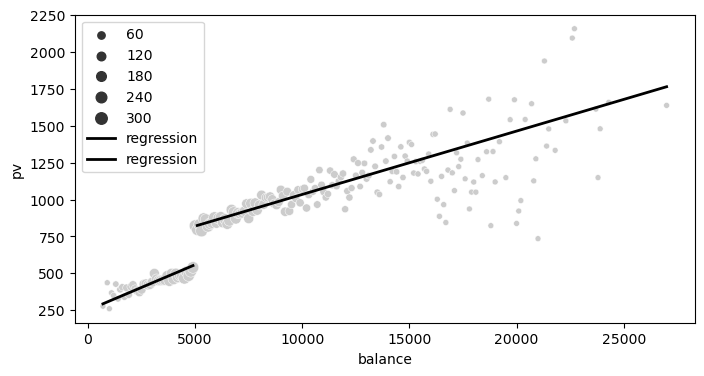

In [89]:
plt_df = (df_dd.round({"balance": -2})  # pd.DataFrame.round() with neg args rounds to nearest 10s/100s etc
              .assign(size=1)           # add a size column with 1s for counting
              .groupby("balance")       # group by balance rounded to nearest 100s 123456 ->round(-2)->123500  
              .agg({"pv": "mean", "size": "sum"}) # average purchase volume and size of each balance group
              .reset_index() # make the balance group a column insted of index
              )  # wrapping in () ensures we can don't need \ at end of each line

plt.figure(figsize=(8,4))
sns.scatterplot(data=plt_df, y="pv", x="balance", size="size", color="C5") # average outcome per balance group
plt.plot(plt_df.query("balance<5000")["balance"], # rounded to nearest 100s so wont affect split on 1000s
        m.predict(plt_df.query("balance<5000").assign(balance = lambda d: d["balance"] - 5000)), # shift to 0
        color="C0", lw=2, label="regression")
plt.plot(plt_df.query("balance>5000")["balance"], 
        m.predict(plt_df.query("balance>5000").assign(balance = lambda d: d["balance"] - 5000)), # shift to 0
        color="C0", lw=2, label="regression")
plt.legend()

#### The IV Estimate 

Since compliance is not 100%, you need to divide the intention-to-treat effect by the compliance rate. In the context of a discontinuity design, that would be how much the treatment probability changes as you cross the threshold. To estimate this number, you can simply repeat the previous procedure, replacing the outcome variable, with the treatment. So you estimate the ITTE and the compliance rate and divide one by the other. Although you could derive a formula to calculate the confidence interval of that estimator, the easiest way is to simply wrap the entire function in a bootstrap procedure.

In [88]:
def rdd_iv(data, y, t, r, cutoff):
    compliance = smf.ols(f"{t}~{r}*I({r}>{cutoff})", data).fit()    # compliance regressing treatment
    itte = smf.ols(f"{y}~{r}*I({r}>{cutoff})", data).fit()          # itte regression outcome 

    param = f"I({r} > {cutoff})[T.True]"                            # parameter name for coefficients
    return itte.params[param]/compliance.params[param]              # access and divide coefficients; late

rdd_iv(df_dd, y="pv", t="prime_card", r="balance", cutoff=10000)    # cutoff???

654.3917626767737

In [104]:
# actual LATE of similated data
(df_dd
.round({"balance": -2})         # round to the nearest hundred
.query("balance==5000 & categ=='complier'")["tau"].mean()  # local (complier) average treatment effect at cutoff
) 

700.0

In [111]:
# bootstraping for confidence interval
from joblib import Parallel, delayed
from toolz import partial

def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(123)

    stats = Parallel(n_jobs=8)(
        delayed(est_fn)(data.sample(frac=1, replace=True))  # bootstrapping step
        for _ in range(rounds)                              # number of bootstrap samples
    )                                               

    return np.percentile(stats, pcts)

bootstrap(df_dd, partial(rdd_iv, y="pv", t="prime_card", r="balance", cutoff=5000))

array([523.53402219, 709.52512328])

#### Bunching

Bunching is a potential issue of the discontinuity design identification. If the units (customers in this case) can manipulate the running variable, they can also self-select into the treatment group. In the prime credit card example, customers could decide to increase their deposits until it reached just 5,000 so that they woud get the prime credit card for free. This would violate the assumption about the smoothness in the potential outcomes, since those just above the threshold would no longer be comparable to those just below it. A simple visual way to check if this is happening is to plot the density around the threshold. If units are are self-selecting into the treatment, you would expect a huge spike in the density at the threshold.

Text(0.5, 0, 'Balance  (rounded to nearest 1000)')

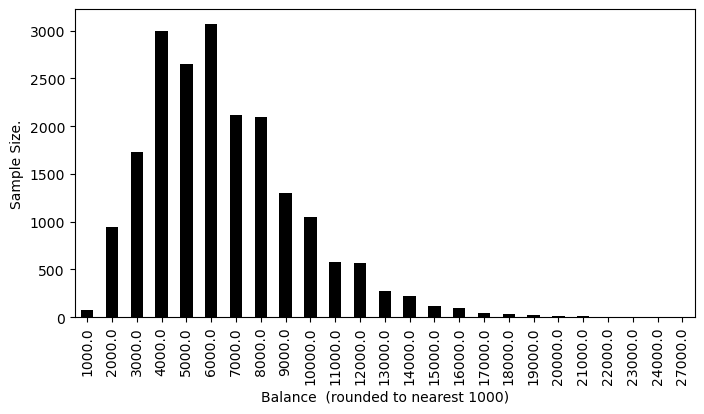

In [113]:
plt.figure(figsize=(8,4))
df_dd.round({"balance": -3}).groupby("balance").size().plot.bar()
plt.ylabel("Sample Size.")
plt.xlabel("Balance  (rounded to nearest 1000)")